In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt
plt.rcParams["text.usetex"] = True
from scipy.integrate import simps
from matplotlib.ticker import FuncFormatter

In [2]:
#Fixed parameter values
pi = 1710; 
#beta1 =1.72;
mu =1/(83*365); 
eps =0.33;   #Youngji paper
tau = 0.8; tau = 0.8;
psi = 0.5; 
phi1, phi2 = 1/180, 1/180
h1= 0.0012; 
h2 = (1-0.74)*h1;
rho = 1/14; rhot =1/10; rhoh =1/10;
eta1= 0.71; eta2= 0.41; eta4= 0.85; eta3 = 0.46;
a = 1/3  # fixed to be 3 days  

theta = 0.5 # parameter adjusting reduced perception risk (assumed)
delta = 0.8  # proportion of tested people who quarantine/adhere to protective measures (assumed)
alpha1, alpha2 = 0.5, 0.5  # parameters which shows to which information people are more concerned

Dtilde, Btilde = 5, 5  # reactivity to information in vaccination
D, B = 1*Dtilde, 1*Btilde # reactivity to information in testing (assumed equal)
Fmax = 0.027; F10 = 0.0029; F20 = (0.9)*F10;
Tmax = 0.5; T10 = 0.03; T20 = 0.03    #Tmax is adjusted to have a good fit

# Fitted parameters
k1=  0.51
beta1=  0.67
beta2=  0.39
xi=  0.99
d1 =0.000071; d2 = 0.000073;  

In [3]:
S1_dfe = pi/(F10 +mu); S2_dfe = (pi*phi1*F10)/((phi1+mu)*(F10+mu)*(F20+mu)); V1_dfe = (pi*F10)/((phi1+mu)*(F10 +mu));
V2_dfe = (pi*phi1*F10*F20)/(mu*(phi1+mu)*(F10+mu)*(F20+mu));
N_dfe = S1_dfe + S2_dfe + V1_dfe + V2_dfe;

C1 = (beta1*S1_dfe)/N_dfe;  C2 = (1/N_dfe)*(beta2*((1-eta2)*S2_dfe + (1-eta4)*V2_dfe) + beta2*(1-eta1)*V1_dfe);
M1 = (eps*(1-tau))/((mu +eps)*(mu+rho+xi*T10))
M2 = (eps*tau)/((mu +eps)*(d1+mu+rho+T10))
M3 = (eps*tau)/((mu +eps)*(d1+mu+rho+T20))
M4 = ( xi*(1-tau)*T10*eps*(d1+mu+rho+T10) + tau*T10*eps*(mu+rho+xi*T10))/((mu +eps)*(d1+mu+rho+T10)*(h1+mu+rhot)*(mu+rho+xi*T10))
M5 = tau*T20*eps/((mu +eps)*(d1+mu+rho+T20)*(h2+mu+rhot))
M6 = (eps*(1-tau))/((mu +eps)*(mu+rho+xi*T20))
M7 = xi*(1-tau)*eps*T20/((mu +eps)*(mu+rho+xi*T20)*(h2+mu+rhot))
R_e = C1*(psi*M1 + M2 + M3 + (1-delta)*(M4+M5)) + C2*(psi*M6 + (1-delta)*M7)
print('Reproduction number =', R_e)

Reproduction number = 0.20083454788859323


In [4]:
# Initial conditions
NN = 51815808
V2_0 = 2891 #int(0.87*Data_Omicron['new_vaccinations'].iloc[0])
V1_0 = 431; #int(0.13*Data_Omicron['new_vaccinations'].iloc[0])
E2_0 = 352645 #int(0.87*20*NewCases.iloc[0])
A2_0 = 70529 #int(0.2*E2_0)
I2_0 = 282116  #int(0.8*E2_0)
IT2_0 = 17632 #int(0.87*NewCases.iloc[0])
E1_0 = 52694 #int(0.13*20*NewCases.iloc[0])  # 0.13 indicates that 13% of the total population is in the first dynamics
A1_0 = 10538 #int(0.2*E1_0)
I1_0 = 42155 #int(0.8*E1_0)
IT1_0 = 2634 #int(0.13*NewCases.iloc[0])
H_0 = 202  # ICU
R_0 = 200
Dth_0 = 15
MV_0 = k1*((I1_0 + I2_0 + IT1_0 + IT2_0 + H_0)/NN)
MN_0 = k1*((H_0 + d1*(I1_0+I2_0) + d2*H_0)/NN)
S2_0 = 40000000 # 0.9*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S3_0 = 4365186 #0.1*(Omicron_New_Cases['people_vaccinated'].iloc[0])
S1_0 = NN-(S2_0 + S3_0 + V1_0 + V2_0 + E1_0 + E2_0 + A1_0 + A2_0 + I1_0 + I2_0 + IT1_0 + IT2_0 + H_0 + R_0)

In [5]:
x0 = [S1_0, S2_0, S3_0, V1_0, V2_0, E1_0, E2_0, A1_0, A2_0, I1_0, I2_0, IT1_0, IT2_0, H_0, R_0, Dth_0, MV_0, MN_0]

In [6]:
def model_eq(x,t):
    S1, S2, S3, V1, V2, E1, E2, A1, A2, I1, I2, I_T1, I_T2, H, R, Dth, MV, MN  = x
    dx = np.zeros(18)
    N= S1 + S2+ S3 + V1 + V2 + E1 + E2 + A1 + A2 + I1 + I2 + I_T1 + I_T2 + H + R
    
    T1 = T10 + (Tmax -T10)*(alpha1*(D*MV)/(1+D*MV) + (1-alpha1)*(B*MN)/(1+B*MN) )
    F1 = F10 + (Fmax -F10)*(alpha1*(Dtilde*MV)/(1+Dtilde*MV) + (1-alpha1)*(Btilde*MN)/(1+Btilde*MN))
    
    T2 = T20 + (Tmax -T20)*(alpha2*(theta*D*MV)/(1+theta*D*MV) + (1-alpha2)*(theta*B*MN)/(1+theta*B*MN) )
    F2 = F20 + (Fmax -F20)*(alpha2*(theta*Dtilde*MV)/(1+theta*Dtilde*MV) + (1-alpha2)*(theta*Btilde*MN)/(1+theta*Btilde*MN))
    
    L1 = beta1*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    L2 = beta2*(I1 + I2 + psi*(A1 + A2) +(1-delta)*(I_T1 + I_T2))/(N-(delta*(I_T1 + I_T2) + H))
    
    dx[0] = pi-(F1 +L1 +mu)*S1
    dx[1] = phi1*V1 -((1-eta2)*L2+F2+mu)*S2
    dx[2] = phi2*R-((1-eta3)*L2+F2+mu)*S3
    dx[3] = F1*S1-phi1*V1-(1-eta1)*L2*V1-mu*V1
    dx[4] = F2*S2+F2*S3-(1-eta4)*L2*V2-mu*V2
    dx[5] = L1*S1-(eps+mu)*E1
    dx[6] = (1-eta1)*L2*V1+(1-eta4)*L2*V2+L2*((1-eta2)*S2+(1-eta3)*S3)-(mu+eps)*E2
    dx[7] = (1-tau)*eps*E1-xi*T1*A1-(rho+mu)*A1
    dx[8] = (1-tau)*eps*E2-xi*T2*A2-(rho+mu)*A2
    dx[9] = tau*eps*E1-T1*I1-(rho+d1+mu)*I1
    dx[10] = tau*eps*E2-T2*I2-(rho+d1+mu)*I2
    dx[11] = xi*T1*A1+T1*I1-(rhot+h1+mu)*I_T1
    dx[12] = xi*T2*A2+T2*I2-(rhot+h2+mu)*I_T2
    dx[13] = h1*I_T1+h2*I_T2-rhoh*H-(d2+mu)*H
    dx[14] = rho*(A1+A2+I1+I2)+rhot*(I_T1+I_T2)+rhoh*H-(phi2+mu)*R
    dx[15] = d1*(I1+I2)+d2*H
    dx[16] = a*(k1*((I_T1+I_T2+I1+I2+H)/NN)-MV)
    dx[17] = a*(k1*((H + d1*(I1 + I2) + d2*H)/NN)-MN)
    return dx

Max when 0% reduction :=  7356634.029184511
Max when 20.0% reduction :=  6380312.7463980485
Max when 50.0% reduction :=  5471128.12677308
Max when 75.0% reduction :=  4965268.835805399
Max when 100% reduction :=  4583735.288068712


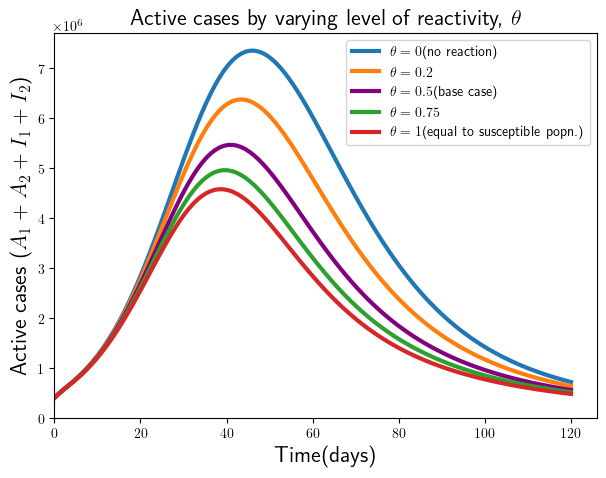

In [7]:
def millions_formatter(x, pos):    
    return f'{(x / 1000000):.0f}'
t = np.linspace(0,120,120)
# base_k = 0.5046
# base_a = 1/5

fig, axs = plt.subplots(1,1,figsize=(7,5))
red11 = [0, 0.2, 0.5, 0.75,1]
                
base_theta = 0.5
for i in range(len(red11)):
    
    theta = red11[i]
    red_per = 100*theta
    x = odeint(model_eq,x0,t)
    In1 = x[:,7]+ x[:,9] + x[:,8]+ x[:,10]
    print(f'Max when {red_per}% reduction := ', max(In1))
    if theta == base_theta:
        plt.plot(t,In1,label=rf'$\theta =  {theta}$(base case)'.format(red_per=red_per),color = 'purple', lw =3)
    elif theta == 0:
        plt.plot(t,In1,label=rf'$\theta =  {theta}$(no reaction)'.format(red_per=red_per), lw =3)
    elif theta == 1:
        plt.plot(t,In1,label=rf'$\theta =  {theta}$(equal to susceptible popn.)'.format(red_per=red_per), lw =3)
    else:        
        plt.plot(t,In1,label=rf'$\theta =  {theta}$'.format(red_per=red_per), lw =3)
    plt.legend(loc='best')
    # listOf_Yticks = np.arange(0, 3700000, 500000)
    # axs[0].set_yticks(listOf_Yticks)
    plt.xlabel('Time(days)',fontsize=16)
    plt.ylabel('Active cases ($A_1 + A_2 + I_1 + I_2$)',fontsize=16)
    #axs.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
    plt.xlim(left =0)
    plt.ylim(bottom = 0)
    plt.title('Active cases by varying level of reactivity, $\\theta$ ', fontsize=16, loc='center')
    
plt.legend() #loc=4,bbox_to_anchor=(1, 0.1)
plt.savefig('effect_of_theta_New_BB_1.pdf', dpi = 600)
plt.show()

Max when 0% of people quaranined :=  11407876.958132774
Max when 25.0% of people quaranined :=  9564864.969684735
Max when 50.0% of people quaranined :=  7854582.320225459
Max when 80.0% of people quaranined :=  6022433.359265354
Max when 100% of people quaranined :=  4950425.341720404


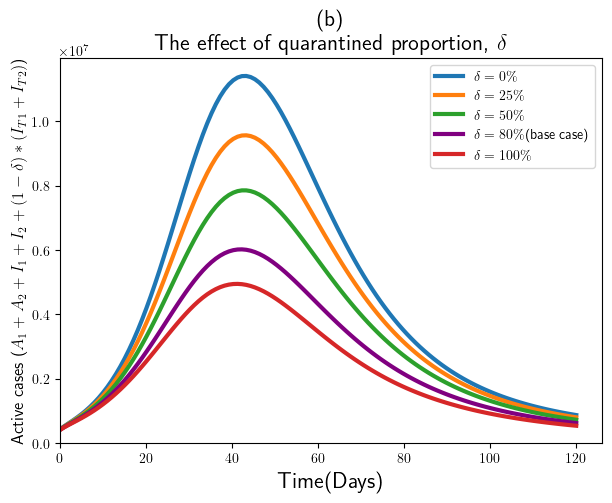

In [8]:
theta =0.5

# base_k = 0.5046
# base_a = 1/5

fig, axs = plt.subplots(1,1,figsize=(7,5))
q11 = [0, 0.25, 0.5, 0.8,1]
                
base_delta = 0.8
for i in range(len(q11)):
    
    delta = q11[i]
    quar = 100*delta
    x = odeint(model_eq,x0,t)
    In1 = x[:,7]+ x[:,9] + x[:,8]+ x[:,10] + (1-delta)*(x[:,11]+ x[:,12])
    print(f'Max when {quar}% of people quaranined := ', max(In1))
    if delta == base_delta:
        plt.plot(t,In1,label=rf'$\delta =  {quar:.0f}\%$(base case)'.format(quar=quar),color = 'purple', lw =3)
    else:
        plt.plot(t,In1,label=rf'$\delta =  {quar:.0f}\%$'.format(quar=quar), lw =3)
    
    plt.legend(loc='best')
    # listOf_Yticks = np.arange(0, 3700000, 500000)
    # axs[0].set_yticks(listOf_Yticks)
    plt.xlabel('Time(Days)',fontsize=16)
    plt.ylabel(r'Active cases ($A_1 + A_2 + I_1 + I_2 +(1-\delta)*(I_{T1} + I_{T2})$)',fontsize=12)
    plt.xlim(left =0)
    plt.ylim(bottom = 0)
    plt.title(r' (b)' '\n The effect of quarantined proportion, $\\delta$ ', fontsize=16)
    
plt.legend()
#plt.savefig('effect_of_delta_New_BB.pdf', dpi = 600)
plt.show()